
# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Agosto 2024


Carlos R. Méndez T.
15Co2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el **Lunes 26 de agosto, 23:59hs**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” a cargar en el siguiente formulario de google: [link](https://docs.google.com/forms/d/e/1FAIpQLSdqvLFa--M6RXuXdg2E9gpvvwyrEbMiqhD6B7cn1ACqwTMc6g/viewform?usp=sf_link)



Recordar compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com así podemos acceder y corregir. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen AGOSTO 2024.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

## Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset CIFAR10, las clases `['cat', 'dog', 'frog']`. Entrene solamente usando las clases mencionadas (ver dataset de ejemplo).

Sobre dicho modelo, evalue el comportamiento de la accuracy bajo los siguientes tamaños de `kernel_size = [5, 7, 9, 11]`.

Grafique la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor. En caso de encontrar overfitting, tome las medidas adecuadas.



In [1]:
#Librerias relacionadas con Pytorch
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

#Librerias relacionadas con el dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Otras
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import os


# Clase para la personalización del Dataset

In [2]:
class FilteredDataset(Dataset):

  def __init__(self, original_dataset, selected_labels):
      self.original_dataset = original_dataset
      self.selected_labels = selected_labels

      # Crear un diccionario para remapear las etiquetas seleccionadas a índices ascendentes
      self.label_map = {label: idx for idx, label in enumerate(selected_labels)}

      # Filtrar los índices de las imágenes que pertenecen a las clases seleccionadas
      self.indices = [i for i, label in enumerate(original_dataset.targets) if label in selected_labels]

  def __len__(self):
      return len(self.indices)

  def __getitem__(self, idx):
      # Obtener el índice del dataset original
      original_idx = self.indices[idx]

      # Obtener la imagen y la etiqueta correspondientes
      image, label = self.original_dataset[original_idx]

      # Remapear la etiqueta
      remapped_label = self.label_map[label]

      return image, remapped_label

# Transformación y filtradro con las clases de interes

In [3]:
# Definir transformaciones para las imágenes
transform = transforms.Compose(
    [transforms.CenterCrop(20),
     transforms.Resize(32),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Transformaciones aplicadas a la data, la normalización para este caso en particular. Se agregaron CenterCrop, Resize, RnadomHorizontalFlip.

Teniendo en cuenta lo expresado en la documentación

https://pytorch.org/vision/0.9/transforms.html

In [4]:
# Descargar y cargar el conjunto de datos CIFAR-10
original_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)

original_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


100%|██████████| 170498071/170498071 [00:02<00:00, 59143984.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:

# Elegir 3 clases específicas (por ejemplo: 'cat', 'dog', 'frog')
classes = original_train_dataset.classes


selected_classes = ['cat', 'dog', 'frog']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

# Crear un nuevo conjunto de datos filtrado
filtered_train_dataset = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset = FilteredDataset(original_test_dataset, selected_class_indices)

# define tamaño de batch
batch_size = 16

# Crear un DataLoader para el nuevo conjunto de datos
trainloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Función para mostrar imágenes
import matplotlib.pyplot as plt
import numpy as np


# Función para visualizar los batches

In [6]:
def imshow(img):

  img = img / 2 + 0.5     # desnormalizar
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [7]:
# Obtener un lote de entrenamiento
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Visualización del batch de prueba

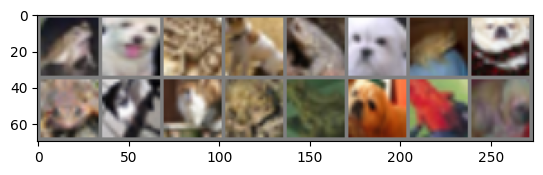

frog dog frog dog frog dog frog dog frog cat cat frog frog dog frog dog


In [8]:
# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))

# Evaluación detallada de la data de imagenes

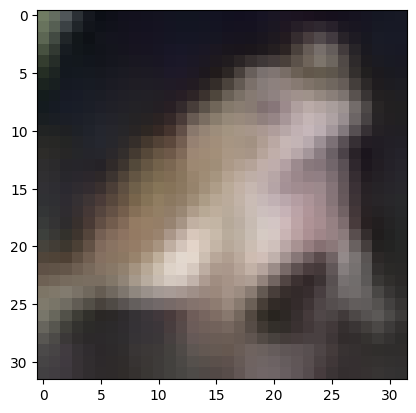

frog
torch.Size([3, 32, 32])


In [9]:
#Validación de la primera imagen
imshow(images[0])

print(' '.join(f'{selected_classes[labels[0]]}' for j in range(1)))
print(images[0].shape)


Las imagenes en **images** tienen 3 canales y 32x32 pixels cada una. Esto es importante para ententer las entradas para nuestra red

# Determinación del device

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cpu


# Arquitectura para la Red Neuronal Convolucional

In [12]:
class DeepCNN(torch.nn.Module):
    """
    Arquitectura de red neuronal convolucional para clasificación de imágenes.
    """
    def __init__(self, n_classes=3, n_outputs=3, kernel_size=5, n_filters_conv1=32):

        super(DeepCNN, self).__init__()

        # Definir las capas convolucionales
        self.conv1 = torch.nn.Conv2d(n_classes, n_filters_conv1, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(n_filters_conv1)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d((2, 2))
        self.dropout1 = torch.nn.Dropout(0.25)

        self.conv2 = torch.nn.Conv2d(n_filters_conv1, 128, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(128)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d((2, 2))
        self.dropout2 = torch.nn.Dropout(0.25)

        # Definir la capa de promedio global de pooling
        self.gap = torch.nn.AdaptiveAvgPool2d((1, 1))

        # Definir las capas totalmente conectadas
        self.linear = torch.nn.Linear(128, 64)
        self.dropout3 = torch.nn.Dropout(0.3)
        self.relu3 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, n_outputs)

    def forward(self, x):
        """
        Paso hacia adelante del modelo CNN.

        Parámetros:
        - x: El lote de imágenes de entrada.

        Retorna:
        - La salida del modelo CNN.
        """
        # Aplicar las capas convolucionales
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        # Aplicar la capa de promedio global de pooling
        x = self.gap(x)

        # Aplanar la salida de las capas convolucionales
        x = x.view(x.size(0), -1)

        # Aplicar las capas totalmente conectadas
        x = self.linear(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.linear2(x)

        return x

In [21]:
class DeepCNN(nn.Module):
    """
    Arquitectura de red neuronal convolucional para clasificación de imágenes.
    """
    def __init__(self, n_classes=3, n_outputs=3, kernel_size=5, n_filters_conv1=32, n_filters_conv2=64, n_filters_conv3=128):
        super(DeepCNN, self).__init__()

        # Definir las capas convolucionales
        self.conv1 = nn.Conv2d(n_classes, n_filters_conv1, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn1 = nn.BatchNorm2d(n_filters_conv1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d((2, 2))
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(n_filters_conv1, n_filters_conv2, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn2 = nn.BatchNorm2d(n_filters_conv2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d((2, 2))
        self.dropout2 = nn.Dropout(0.25)

        # Nueva capa convolucional
        self.conv3 = nn.Conv2d(n_filters_conv2, n_filters_conv3, kernel_size=kernel_size, padding=kernel_size//2, stride=1)
        self.bn3 = nn.BatchNorm2d(n_filters_conv3)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d((2, 2))
        self.dropout3 = nn.Dropout(0.25)

        # Definir la capa de promedio global de pooling
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # Definir las capas totalmente conectadas
        self.linear = nn.Linear(n_filters_conv3, 64)
        self.dropout4 = nn.Dropout(0.3)
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(64, n_outputs)

    def forward(self, x):
        """
        Paso hacia adelante del modelo CNN.

        Parámetros:
        - x: El lote de imágenes de entrada.

        Retorna:
        - La salida del modelo CNN.
        """
        # Aplicar las capas convolucionales
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        # Aplicar la nueva capa convolucional
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)

        # Aplicar la capa de promedio global de pooling
        x = self.gap(x)

        # Aplanar la salida de las capas convolucionales
        x = x.view(x.size(0), -1)

        # Aplicar las capas totalmente conectadas
        x = self.linear(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.linear2(x)

        return x

In [14]:
model = DeepCNN()

model.to(device)
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          51,264
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]         204,928
      BatchNorm2d-12            [-1, 128, 8, 8]             256
             ReLU-13            [-1, 128, 8, 8]               0
        MaxPool2d-14            [-1, 12

# Definición del entrenamiento

In [15]:
def fit(model, dataloader, epochs=15, device='cpu'):
    """
    Entrena el modelo utilizando los datos proporcionados.

    Parámetros:
    - model: El modelo a entrenar.
    - dataloader: Un diccionario que contiene los objetos DataLoader para entrenamiento y validación.
    - epochs: El número de épocas para el entrenamiento.
    - device: El dispositivo a utilizar para el entrenamiento ('cuda' o 'cpu').

    Devuelve:
    - Un diccionario que contiene las métricas de entrenamiento y validación.
    """
    # Mueve el modelo al dispositivo especificado
    model.to(device)

    # Define el optimizador y la función de pérdida
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    # Listas para almacenar las métricas de cada época
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []

    for epoch in range(1, epochs + 1):
        # Establece el modelo en modo de entrenamiento
        model.train()

        # Inicializa la pérdida y la precisión de entrenamiento
        train_loss = []
        train_acc = []

        # Bucle de entrenamiento
        for batch in dataloader['train']:
            # Obtiene los datos de entrada y los mueve al dispositivo
            X, y = batch
            X, y = X.to(device), y.to(device)

            # Pone a cero los gradientes
            optimizer.zero_grad()

            # Paso hacia adelante (forward pass)
            y_hat = model(X)

            # Calcula la pérdida
            loss = criterion(y_hat, y)

            # Paso hacia atrás (backward pass)
            loss.backward()

            # Actualiza los pesos
            optimizer.step()

            # Almacena la pérdida y la precisión para este lote
            train_loss.append(loss.item())
            acc = (y_hat.argmax(dim=1) == y).sum().item() / len(y)
            train_acc.append(acc)

        # Calcula y almacena la pérdida de entrenamiento promedio y la precisión para esta época
        avg_train_loss = sum(train_loss) / len(train_loss)
        avg_train_acc = sum(train_acc) / len(train_acc)
        epoch_t_loss.append(avg_train_loss)
        epoch_t_acc.append(avg_train_acc)

        # Establece el modelo en modo de evaluación
        model.eval()

        # Inicializa la pérdida y la precisión de validación
        val_loss = []
        val_acc = []

        # Desactiva el cálculo de gradientes
        with torch.no_grad():
            for batch in dataloader['test']:
                # Bucle de validación
                # Obtiene los datos de entrada y los mueve al dispositivo
                X, y = batch
                X, y = X.to(device), y.to(device)

                # Paso hacia adelante
                y_hat = model(X)

                # Calcula la pérdida
                loss = criterion(y_hat, y)

                # Almacena la pérdida y la precisión para este lote
                val_loss.append(loss.item())
                acc = (y_hat.argmax(dim=1) == y).sum().item() / len(y)
                val_acc.append(acc)

        # Calcula y almacena la pérdida de validación promedio y la precisión para esta época
        avg_val_loss = sum(val_loss) / len(val_loss)
        avg_val_acc = sum(val_acc) / len(val_acc)
        epoch_v_loss.append(avg_val_loss)
        epoch_v_acc.append(avg_val_acc)

        # Imprime el resumen después de cada época
        print(f"Época {epoch}/{epochs} | "
              f"Pérdida de Entrenamiento: {avg_train_loss:.4f} | Precisión de Entrenamiento: {avg_train_acc:.4f} | "
              f"Pérdida de Validación: {avg_val_loss:.4f} | Precisión de Validación: {avg_val_acc:.4f}")

    return {
        'train_loss': epoch_t_loss,
        'val_loss': epoch_v_loss,
        'train_acc': epoch_t_acc,
        'val_acc': epoch_v_acc
    }



In [16]:
def hist_plot(history):
    """
    Grafica las métricas de entrenamiento y validación.

    Parámetros:
    - history: Un diccionario que contiene las métricas de entrenamiento y validación.
    """
    # Obtiene el número de épocas
    epochs = range(1, len(history['train_loss']) + 1)

    # Crea una figura y un conjunto de subplots
    plt.figure(figsize=(12, 6))

    # Graficar la pérdida de Entrenamiento y Validación
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Pérdida de Entrenamiento', color='royalblue', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Pérdida de Validación', color='darkorange', linewidth=2)
    plt.title('Pérdida (Loss) de Entrenamiento y Validación', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Pérdida', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    # Graficar la Precisión de Entrenamiento y Validación
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Precisión de Entrenamiento', color='royalblue', linewidth=2)
    plt.plot(epochs, history['val_acc'], label='Precisión de Validación', color='darkorange', linewidth=2)
    plt.title('Precisión (Accuracy) de Entrenamiento y Validación', fontsize=16)
    plt.xlabel('Épocas', fontsize=14)
    plt.ylabel('Precisión', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [22]:
def evaluate_model(model, dataloader, class_names, device='cpu'):
    """
    Evalúa el modelo en el conjunto de datos de prueba.

    Parámetros:
    - model: El modelo entrenado.
    - dataloader: El DataLoader que contiene los datos de prueba.
    - class_names: Lista con los nombres de las clases.
    - device: El dispositivo a utilizar para la evaluación ('cuda' o 'cpu').

    Retorna:
    - accuracy: La precisión del modelo en el conjunto de prueba.
    """
    model.to(device)
    model.eval()  # Establece el modelo en modo de evaluación

    criterion = nn.CrossEntropyLoss()  # Función de pérdida
    correct = 0
    total = 0

    predictions = []
    actual_labels = []

    with torch.no_grad():  # Desactiva el cálculo de gradientes
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

    # Crear la matriz de confusión
    cm = confusion_matrix(actual_labels, predictions)

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriz de Confusión')
    plt.show()

    accuracy = 100 * correct / total
    print(f'Precisión del modelo en el conjunto de prueba: {accuracy:.2f}%')

    return accuracy

In [17]:
def save_model(model, history, path="/models", filename_prefix="model"):
    """
    Guarda el modelo con un nombre de archivo que incluye la pérdida y la precisión de validación final.

    Parámetros:
    - model: El modelo de PyTorch que se guardará.
    - history: Un diccionario que contiene el historial de entrenamiento con las claves 'val_loss' y 'val_acc'.
    - path: La ruta del directorio donde se guardará el modelo (por defecto es el directorio actual).
    - filename_prefix: Un prefijo para el nombre del archivo (por defecto es "model").

    Retorna:
    - full_path: La ruta completa del archivo donde se guardó el modelo.
    """
    # Métricas
    loss = history['val_loss'][-1]
    acc = history['val_acc'][-1]

    # Crear el nombre del archivo
    model_filename = f"{filename_prefix}_loss{loss:.2f}_acc{acc:.2f}.pth"

    # Combinar la ruta y el nombre del archivo
    full_path = os.path.join(path, model_filename)

    # Guardar el modelo en un archivo
    # usa la función save de torch
    torch.save(model.state_dict(), full_path)

    print(f'Modelo guardado {full_path}')
    #return full_path


In [ ]:
model = DeepCNN()
history = fit(model, {'train': trainloader, 'test': testloader}, epochs=15)

Época 1/15 | Pérdida de Entrenamiento: 0.9130 | Precisión de Entrenamiento: 0.5430 | Pérdida de Validación: 0.8341 | Precisión de Validación: 0.6034
Época 2/15 | Pérdida de Entrenamiento: 0.8258 | Precisión de Entrenamiento: 0.5983 | Pérdida de Validación: 0.7611 | Precisión de Validación: 0.6430
Época 3/15 | Pérdida de Entrenamiento: 0.7962 | Precisión de Entrenamiento: 0.6230 | Pérdida de Validación: 0.7284 | Precisión de Validación: 0.6676
Época 4/15 | Pérdida de Entrenamiento: 0.7691 | Precisión de Entrenamiento: 0.6368 | Pérdida de Validación: 0.7299 | Precisión de Validación: 0.6616
Época 5/15 | Pérdida de Entrenamiento: 0.7501 | Precisión de Entrenamiento: 0.6501 | Pérdida de Validación: 0.7271 | Precisión de Validación: 0.6539
Época 6/15 | Pérdida de Entrenamiento: 0.7324 | Precisión de Entrenamiento: 0.6634 | Pérdida de Validación: 0.7029 | Precisión de Validación: 0.6622
Época 7/15 | Pérdida de Entrenamiento: 0.7210 | Precisión de Entrenamiento: 0.6638 | Pérdida de Validación

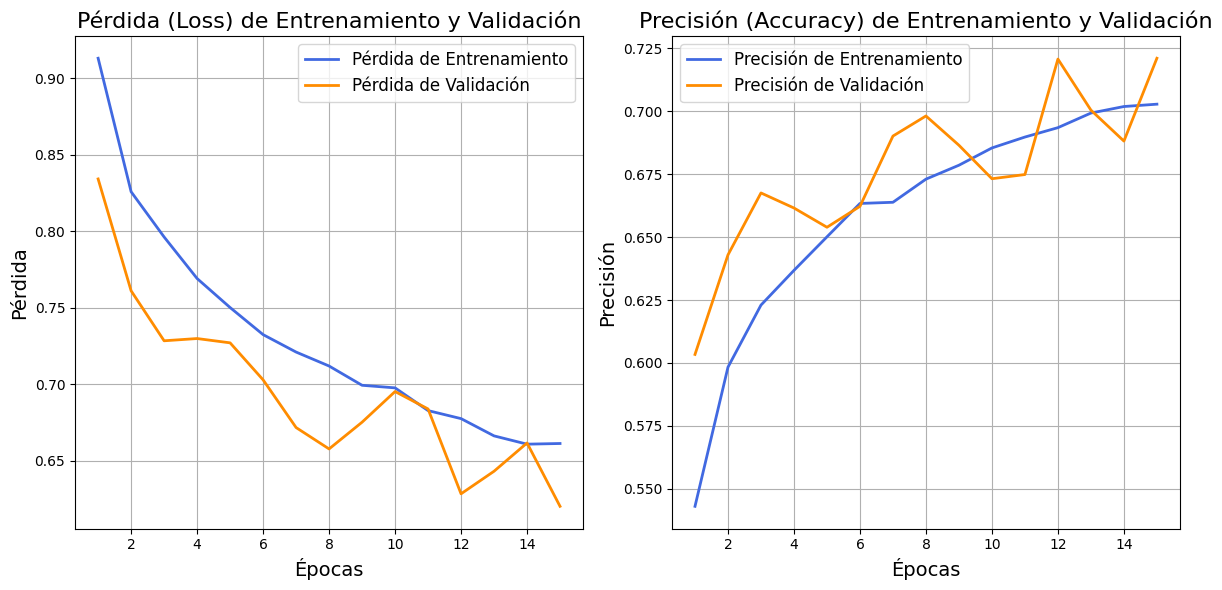

In [ ]:
hist_plot(history)

Las gráficas, el modelo alcanza una precisión aproximada de 0.7028 en el conjunto de entrenamiento y 0.7211 en el conjunto de validación.

No se eividencia overfiting durante el entrenamiento

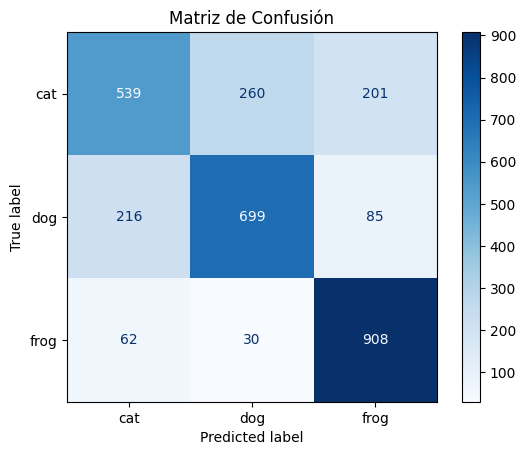

Precisión del modelo en el conjunto de prueba: 71.53%


In [ ]:
# Evaluación del modelo
results = evaluate_model(model, testloader, ['cat', 'dog', 'frog'])

In [ ]:
saved_model = save_model(model, history)

Modelo guardado /content/sample_data/models/model_loss0.62_acc0.72.pth


# Validación con diferentes valores de kernel

# kernel_size=7

In [ ]:
model_kernel_7 = DeepCNN(kernel_size=7)
hist_kernel_7 = fit(model_kernel_7, {'train': trainloader, 'test': testloader}, epochs=15)

Época 1/15 | Pérdida de Entrenamiento: 0.8949 | Precisión de Entrenamiento: 0.5588 | Pérdida de Validación: 0.8013 | Precisión de Validación: 0.6227
Época 2/15 | Pérdida de Entrenamiento: 0.8095 | Precisión de Entrenamiento: 0.6067 | Pérdida de Validación: 0.7525 | Precisión de Validación: 0.6330
Época 3/15 | Pérdida de Entrenamiento: 0.7772 | Precisión de Entrenamiento: 0.6296 | Pérdida de Validación: 0.7104 | Precisión de Validación: 0.6649
Época 4/15 | Pérdida de Entrenamiento: 0.7484 | Precisión de Entrenamiento: 0.6497 | Pérdida de Validación: 0.7121 | Precisión de Validación: 0.6582
Época 5/15 | Pérdida de Entrenamiento: 0.7315 | Precisión de Entrenamiento: 0.6614 | Pérdida de Validación: 0.6915 | Precisión de Validación: 0.6792
Época 6/15 | Pérdida de Entrenamiento: 0.7193 | Precisión de Entrenamiento: 0.6716 | Pérdida de Validación: 0.7156 | Precisión de Validación: 0.6589
Época 7/15 | Pérdida de Entrenamiento: 0.7029 | Precisión de Entrenamiento: 0.6803 | Pérdida de Validación

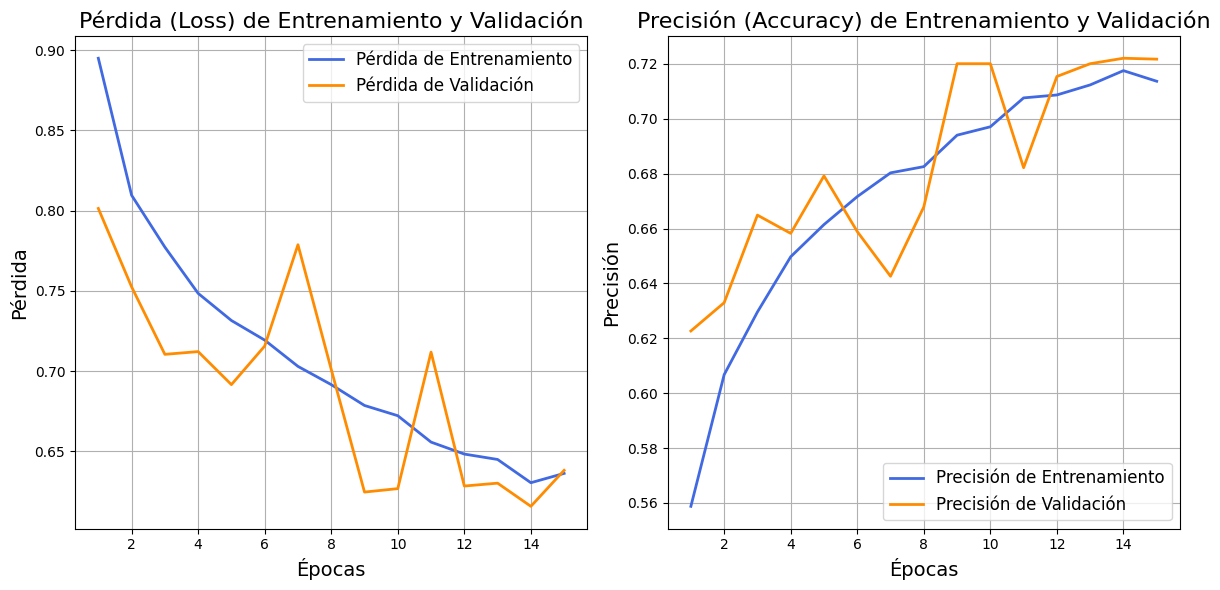

In [ ]:
hist_plot(hist_kernel_7)

Las gráficas, el modelo alcanza una precisión aproximada de 0.7137 en el conjunto de entrenamiento y 0.7217 en el conjunto de validación.

No se eividencia overfiting durante el entrenamiento

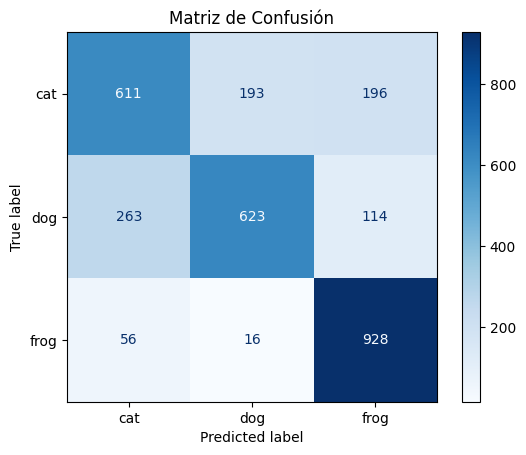

Precisión del modelo en el conjunto de prueba: 72.07%


In [ ]:
# Evaluación del modelo con kernel_size=7
results_7 = evaluate_model(model_kernel_7, testloader, ['cat', 'dog', 'frog'])

In [ ]:
saved_model_7 = save_model(model_kernel_7, hist_kernel_7)

Modelo guardado /content/sample_data/models/model_loss0.64_acc0.72.pth


# kernel_size=9

In [ ]:
model_kernel_9 = DeepCNN(kernel_size=9)
hist_kernel_9 = fit(model_kernel_9, {'train': trainloader, 'test': testloader}, epochs=15)

Época 1/15 | Pérdida de Entrenamiento: 0.8913 | Precisión de Entrenamiento: 0.5618 | Pérdida de Validación: 0.7923 | Precisión de Validación: 0.6140
Época 2/15 | Pérdida de Entrenamiento: 0.8081 | Precisión de Entrenamiento: 0.6153 | Pérdida de Validación: 0.7710 | Precisión de Validación: 0.6420
Época 3/15 | Pérdida de Entrenamiento: 0.7733 | Precisión de Entrenamiento: 0.6347 | Pérdida de Validación: 0.7300 | Precisión de Validación: 0.6489
Época 4/15 | Pérdida de Entrenamiento: 0.7539 | Precisión de Entrenamiento: 0.6488 | Pérdida de Validación: 0.7017 | Precisión de Validación: 0.6742
Época 5/15 | Pérdida de Entrenamiento: 0.7314 | Precisión de Entrenamiento: 0.6630 | Pérdida de Validación: 0.6845 | Precisión de Validación: 0.6809
Época 6/15 | Pérdida de Entrenamiento: 0.7215 | Precisión de Entrenamiento: 0.6702 | Pérdida de Validación: 0.8420 | Precisión de Validación: 0.6333
Época 7/15 | Pérdida de Entrenamiento: 0.7011 | Precisión de Entrenamiento: 0.6813 | Pérdida de Validación

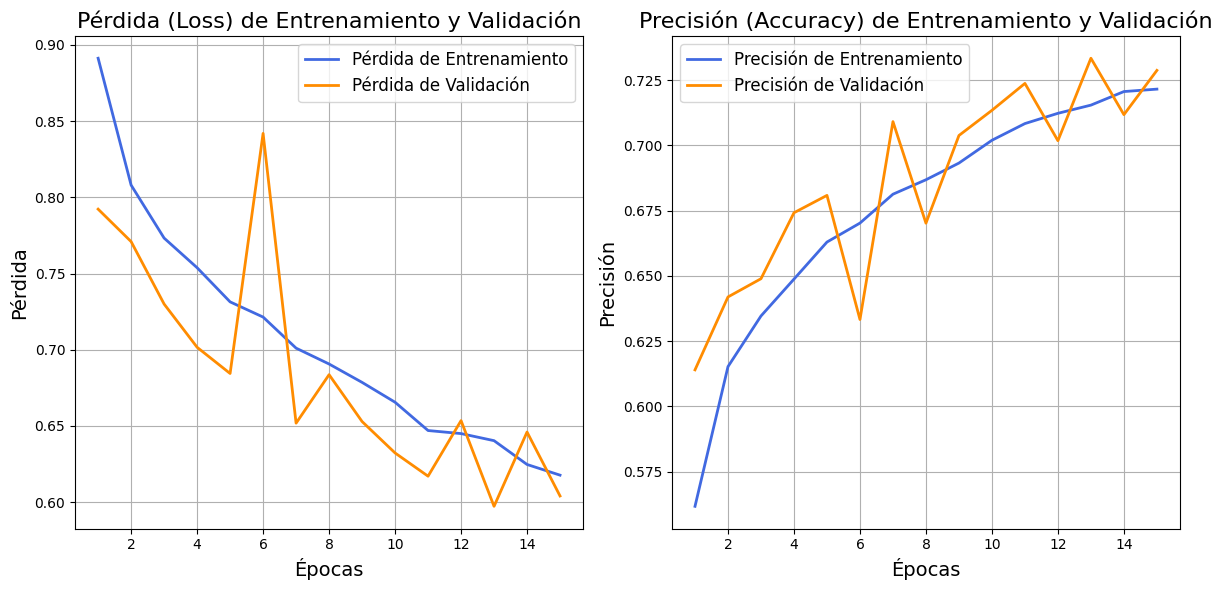

In [ ]:
hist_plot(hist_kernel_9)

Las gráficas, el modelo alcanza una precisión aproximada de 0.7215 en el conjunto de entrenamiento y 0.7287 en el conjunto de validación.

No se eividencia overfiting durante el entrenamiento

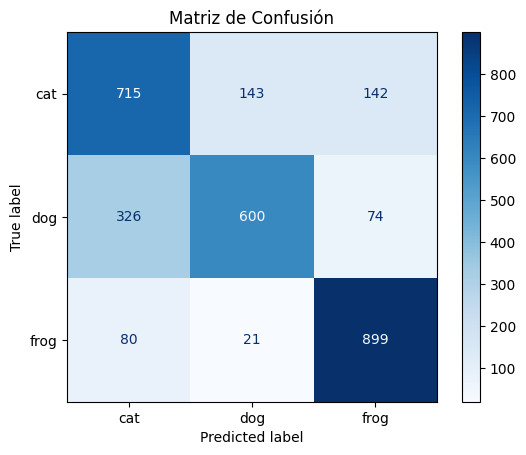

Precisión del modelo en el conjunto de prueba: 73.80%


In [ ]:
# Evaluación del modelo con kernel_size=9
results_9 = evaluate_model(model_kernel_9, testloader, ['cat', 'dog', 'frog'])

In [ ]:
saved_model_9 = save_model(model_kernel_9, hist_kernel_9)

Modelo guardado /content/sample_data/models/model_loss0.60_acc0.73.pth


# kernel_size = 11

In [18]:
model_kernel_11 = DeepCNN(kernel_size=11)
hist_kernel_11 = fit(model_kernel_11, {'train': trainloader, 'test': testloader}, epochs=15)

Época 1/15 | Pérdida de Entrenamiento: 0.8988 | Precisión de Entrenamiento: 0.5529 | Pérdida de Validación: 0.8376 | Precisión de Validación: 0.5881
Época 2/15 | Pérdida de Entrenamiento: 0.8193 | Precisión de Entrenamiento: 0.6119 | Pérdida de Validación: 0.7540 | Precisión de Validación: 0.6346
Época 3/15 | Pérdida de Entrenamiento: 0.7887 | Precisión de Entrenamiento: 0.6261 | Pérdida de Validación: 0.7439 | Precisión de Validación: 0.6513
Época 4/15 | Pérdida de Entrenamiento: 0.7613 | Precisión de Entrenamiento: 0.6391 | Pérdida de Validación: 0.7463 | Precisión de Validación: 0.6436
Época 5/15 | Pérdida de Entrenamiento: 0.7396 | Precisión de Entrenamiento: 0.6550 | Pérdida de Validación: 0.7023 | Precisión de Validación: 0.6672
Época 6/15 | Pérdida de Entrenamiento: 0.7256 | Precisión de Entrenamiento: 0.6676 | Pérdida de Validación: 0.7576 | Precisión de Validación: 0.6366
Época 7/15 | Pérdida de Entrenamiento: 0.7127 | Precisión de Entrenamiento: 0.6690 | Pérdida de Validación

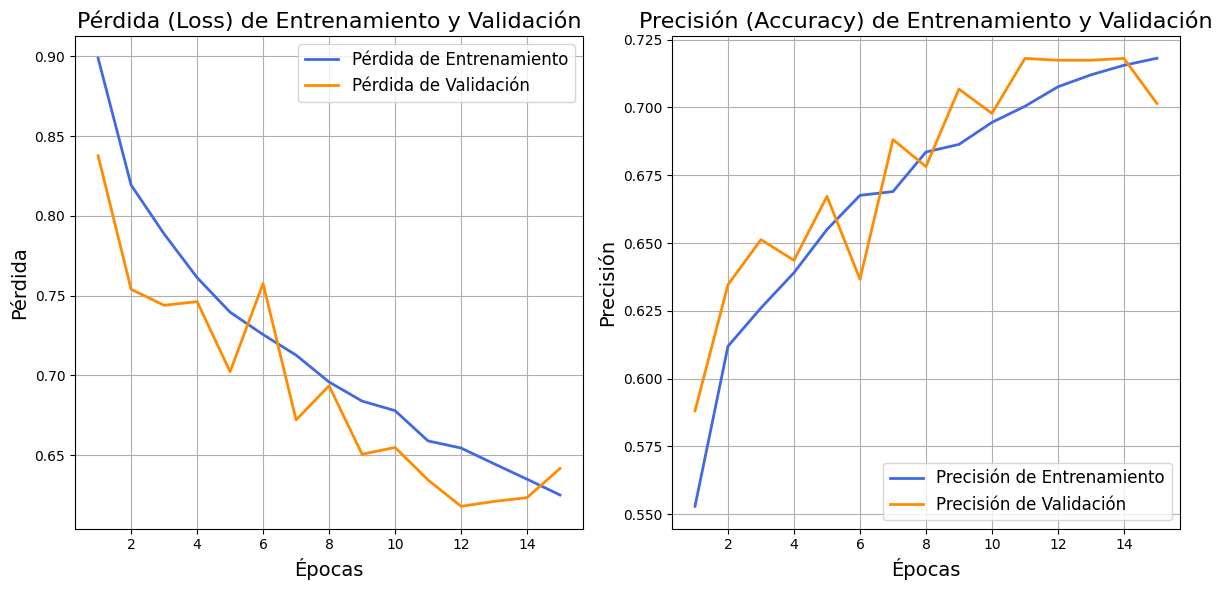

In [19]:
hist_plot(hist_kernel_11)

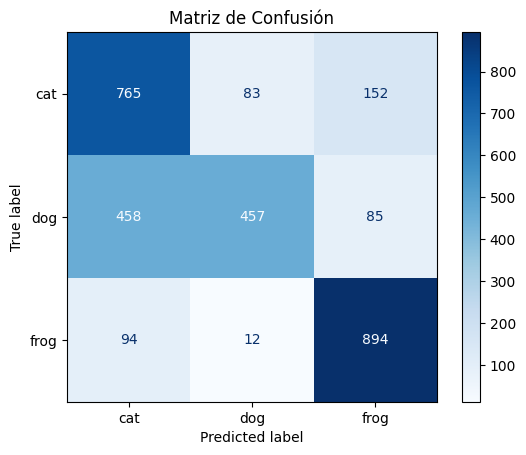

Precisión del modelo en el conjunto de prueba: 70.53%


In [23]:
results_11 = evaluate_model(model_kernel_11, testloader, ['cat', 'dog', 'frog'])

In [24]:
saved_model_11 = save_model(model_kernel_11, hist_kernel_11)

Modelo guardado /content/sample_data/models/model_loss0.64_acc0.70.pth


# Conclusiones

Para la configuración y el número de epocas planteadas, el modelo con mejor predicción fue el que tenía kernel_size=9.

# Parte 2b - Transfer Learning

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para indentificar del mismo dataset CIFAR10 las clases ['plane', 'car'].

Compare la evolución de la función de perdida y accuracy realizando transfer learning vs entrenando el modelo desde cero.

Compare los resultados finales y comente.

Para el caso de análisis se seleccionan las clases **['plane','car']**

In [25]:
classes = original_train_dataset.classes
selected_classes = ['airplane', 'automobile']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

Se reutilizan las funciones de la parte 1a, para filtrar las clases seleccionadas.

In [26]:
filtered_train_dataset = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset = FilteredDataset(original_test_dataset, selected_class_indices)

Se crea el dataloader con un batch_size de 16

In [27]:
# Se determina el batch size
batch_size = 16

# Crea DataLoaders para el nuevo conjunto de datos
trainloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Se muestra las imagenes contenidas en batch

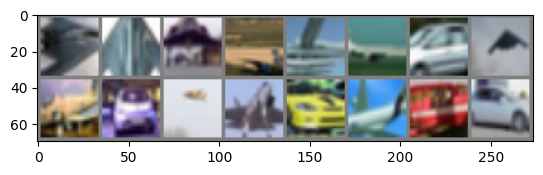

airplane airplane airplane airplane airplane airplane automobile airplane airplane automobile airplane airplane automobile airplane airplane automobile


In [28]:
# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display images from the batch
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))

# Transfer Learning

Se realiza la carga del modelo con mejor perfomarce para trabajar


In [29]:
# Load the model
transfered = DeepCNN()
transfered.load_state_dict(torch.load('/content/sample_data/models/model_loss0.62_acc0.72.pth', weights_only=True))

<All keys matched successfully>

Para el caso de estudio debemos modificar el output, que para el caso previo eran tres clases.

In [30]:
transfered.linear2

Linear(in_features=64, out_features=3, bias=True)

y ahora son dos

In [32]:
# Change the number of output classes
transfered.linear2 = torch.nn.Linear(64, 2)
transfered.to(device)

DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (gap

In [33]:
history_transfered = fit(transfered, {'train': trainloader, 'test': testloader}, epochs=10)

Época 1/10 | Pérdida de Entrenamiento: 0.4543 | Precisión de Entrenamiento: 0.7908 | Pérdida de Validación: 0.3631 | Precisión de Validación: 0.8500
Época 2/10 | Pérdida de Entrenamiento: 0.3464 | Precisión de Entrenamiento: 0.8525 | Pérdida de Validación: 0.2921 | Precisión de Validación: 0.8850
Época 3/10 | Pérdida de Entrenamiento: 0.3096 | Precisión de Entrenamiento: 0.8730 | Pérdida de Validación: 0.2663 | Precisión de Validación: 0.8880
Época 4/10 | Pérdida de Entrenamiento: 0.2976 | Precisión de Entrenamiento: 0.8719 | Pérdida de Validación: 0.2953 | Precisión de Validación: 0.8755
Época 5/10 | Pérdida de Entrenamiento: 0.2814 | Precisión de Entrenamiento: 0.8814 | Pérdida de Validación: 0.2493 | Precisión de Validación: 0.9010
Época 6/10 | Pérdida de Entrenamiento: 0.2675 | Precisión de Entrenamiento: 0.8915 | Pérdida de Validación: 0.2177 | Precisión de Validación: 0.9130
Época 7/10 | Pérdida de Entrenamiento: 0.2586 | Precisión de Entrenamiento: 0.8955 | Pérdida de Validación

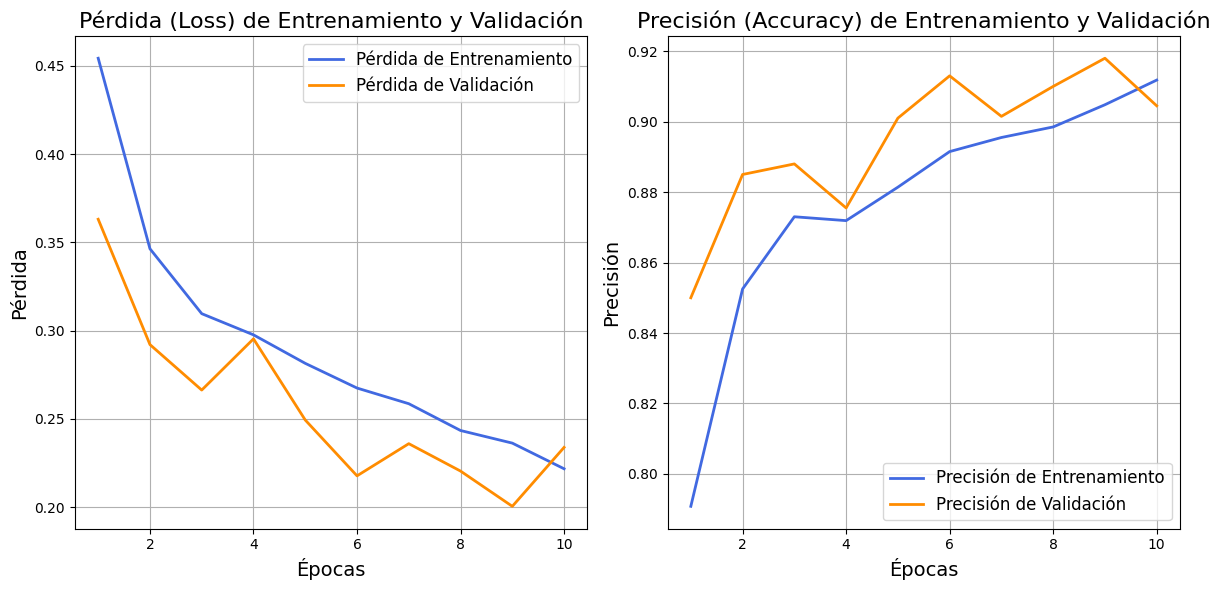

In [34]:
hist_plot(history_transfered)

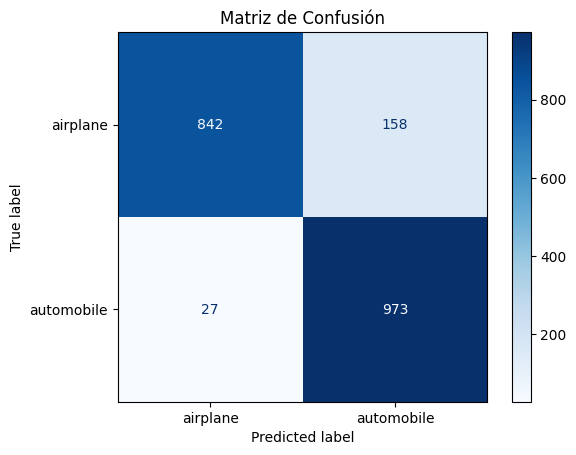

Precisión del modelo en el conjunto de prueba: 90.75%


In [35]:
# Evaluación del modelo
results_transfered = evaluate_model(transfered, testloader, ['airplane', 'automobile'])

El modelo tiene un performance bueno (**90,75%**) y parece generalizar bastante bien las clases nuevas.

# Comparar contra el entrenamiento desde cero

Se requiere comparar el modelo con transfer learning versus el de un modelo entrenado desde cero, para ello se entrenará otro modelo (manteniendo la arquitectura) tomando en cuenta que las clases a clasificar ['airplanne', 'automobile].


In [ ]:
from_zero_model = DeepCNN()

# Ajusta al numero de clases para conservar la estructura pero entrenar desde cero
from_zero_model.linear2 = torch.nn.Linear(64, 2)
from_zero_model.to(device)

DeepCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (gap): 

In [ ]:
history_fromzero = fit(from_zero_model, {'train': trainloader, 'test': testloader}, epochs=10)



Época 1/10 | Pérdida de Entrenamiento: 0.5329 | Precisión de Entrenamiento: 0.7350 | Pérdida de Validación: 0.4130 | Precisión de Validación: 0.8250
Época 2/10 | Pérdida de Entrenamiento: 0.4078 | Precisión de Entrenamiento: 0.8250 | Pérdida de Validación: 0.3266 | Precisión de Validación: 0.8690
Época 3/10 | Pérdida de Entrenamiento: 0.3566 | Precisión de Entrenamiento: 0.8516 | Pérdida de Validación: 0.3212 | Precisión de Validación: 0.8630
Época 4/10 | Pérdida de Entrenamiento: 0.3388 | Precisión de Entrenamiento: 0.8561 | Pérdida de Validación: 0.3356 | Precisión de Validación: 0.8450
Época 5/10 | Pérdida de Entrenamiento: 0.3173 | Precisión de Entrenamiento: 0.8666 | Pérdida de Validación: 0.2790 | Precisión de Validación: 0.8855
Época 6/10 | Pérdida de Entrenamiento: 0.3159 | Precisión de Entrenamiento: 0.8679 | Pérdida de Validación: 0.2561 | Precisión de Validación: 0.8965
Época 7/10 | Pérdida de Entrenamiento: 0.3046 | Precisión de Entrenamiento: 0.8701 | Pérdida de Validación

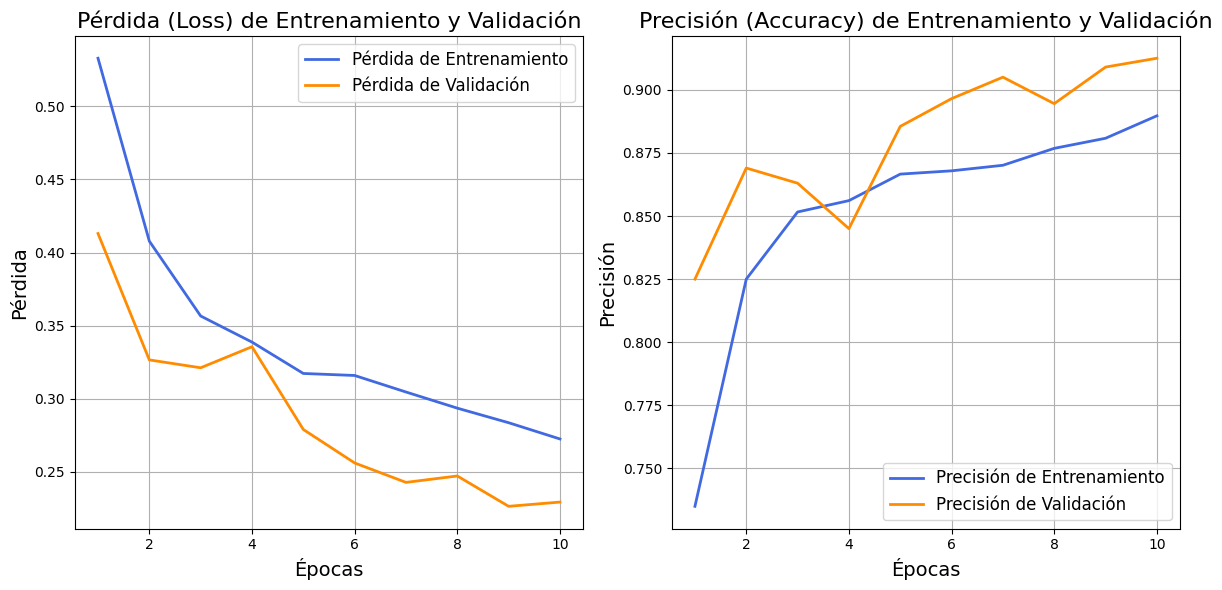

In [ ]:
hist_plot(history_fromzero)

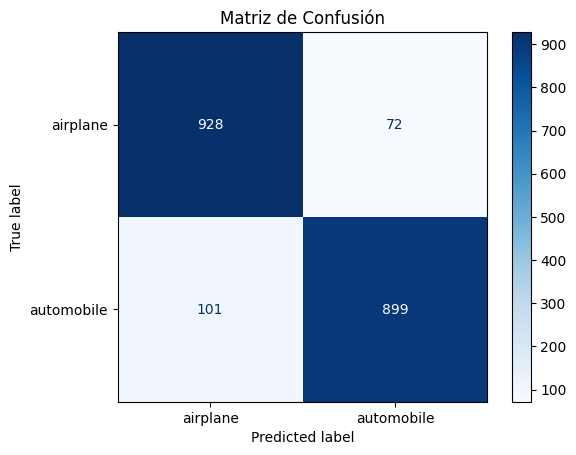

Precisión del modelo en el conjunto de prueba: 91.35%


In [ ]:
results_fromzero = evaluate_model(from_zero_model, testloader, ['airplane', 'automobile'])

A modo de cierre ambos modelos realizan un buen perfomance y están generalizando de manera apropiada el dataset en análisis, sin embargo cuando se usa la técnica de transfer learning se reducen los cálculos de manera significativa porque sólo tendríamos que entrenar los parámetros de la última capa.